# Reducing Numerical Errors with Deep Learning

First, we'll target numerical errors that arise in the discretization of a continuous PDE $\mathcal P^*$, i.e. when we formulate $\mathcal P$. This approach will demonstrate that, despite the lack of closed-form descriptions, discretization errors often are functions with regular and repeating structures and, thus, can be learned by a neural network. Once the network is trained, it can be evaluated locally to improve the solution of a PDE-solver, i.e., to reduce its numerical error. The resulting method is a hybrid one: it will always run (a coarse) PDE solver, and then improve if at runtime with corrections inferred by an NN.
 
Pretty much all numerical methods contain some form of iterative process. That can be repeated updates over time for explicit solvers,or within a single update step for implicit solvers. Below we'll target iterations over time, an example for the second case could be found [here](https://github.com/tum-pbs/CG-Solver-in-the-Loop).

## Problem Formulation

In the context of reducing errors, it's crucial to have a _differentiable physics solver_, so that the learning process can take the reaction of the solver into account. This interaction is not possible with supervised learning or PINN training. Even small inference errors of a supervised NN can accumulate over time, and lead to a data distribution that differs from the distribution of the pre-computed data. This distribution shift can lead to sub-optimal results, or even cause blow-ups of the solver.

In order to learn the error function, we'll consider two different discretizations of the same PDE $\mathcal P^*$: 
a _reference_ version, which we assume to be accurate, with a discretized version 
$\mathcal P_r$, and solutions $\mathbf r \in \mathscr R$, where $\mathscr R$ denotes the manifold of solutions of $\mathcal P_r$.
In parallel to this, we have a less accurate approximation of the same PDE, which we'll refer to as the _source_ version, as this will be the solver that our NN should later on interact with. Analogously,
we have $\mathcal P_s$ with solutions $\mathbf s \in \mathscr S$.
After training, we'll obtain a _hybrid_ solver that uses $\mathcal P_s$ in conjunction with a trained network to obtain improved solutions, i.e., solutions that are closer to the ones produced by $\mathcal P_r$.

```{figure} resources/diffphys-sol-manifolds.jpeg
---
height: 150px
name: diffphys-sol-manifolds
---
Visual overview of coarse and reference manifolds
```



Let's assume $\mathcal{P}$ advances a solution by a time step $\Delta t$, and let's denote $n$ consecutive steps by a superscript:
$
\newcommand{\pde}{\mathcal{P}}
\newcommand{\pdec}{\pde_{s}}
\newcommand{\vc}[1]{\mathbf{s}_{#1}} 
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\newcommand{\vcN}{\vs}          
\newcommand{\project}{\mathcal{T}}   
\vc{t+n} = \pdec(\pdec(\cdots \pdec( \mathcal{T} \vr{t}  )\cdots)) = \pdec^n ( \mathcal{T} \vr{t} ) .
$
Here we assume a mapping operator $\mathcal{T}$ exists that transfers a reference solution to the source manifold. This could, e.g., be a simple downsampling operation.
Especially for longer sequences, i.e. larger $n$, the source state 
$\newcommand{\vc}[1]{\mathbf{s}_{#1}} \vc{t+n}$
will deviate from a corresponding reference state
$\newcommand{\vr}[1]{\mathbf{r}_{#1}} \vr{t+n}$. 
This is what we will address with an NN in the following.

We'll use an $L^2$-norm in the following to quantify the deviations, i.e., 
an error function $\newcommand{\loss}{e} 
\newcommand{\corr}{\mathcal{C}} 
\newcommand{\vc}[1]{\mathbf{s}_{#1}} 
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\loss (\vc{t},\mathcal{T} \vr{t})=\Vert\vc{t}-\mathcal{T} \vr{t}\Vert_2$. 
Our learning goal is to train at a correction operator 
$\mathcal{C} ( \mathbf{s} )$ such that 
a solution to which the correction is applied has a lower error than the original unmodified (source) 
solution: $\newcommand{\loss}{e} 
\newcommand{\corr}{\mathcal{C}} 
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\loss ( \mathcal{P}_{s}( \corr (\mathcal{T} \vr{t_0}) ) , \mathcal{T} \vr{t_1}) < \loss ( \mathcal{P}_{s}( \mathcal{T} \vr{t_0} ), \mathcal{T} \vr{t_1})$. 

The correction function 
$\newcommand{\vcN}{\mathbf{s}} \newcommand{\corr}{\mathcal{C}} \corr (\vcN | \theta)$ 
is represented as a deep neural network with weights $\theta$
and receives the state $\mathbf{s}$ to infer an additive correction field with the same dimension.
To distinguish the original states $\mathbf{s}$ from the corrected ones, we'll denote the latter with an added tilde $\tilde{\mathbf{s}}$.
The overall learning goal now becomes

$
\newcommand{\corr}{\mathcal{C}}  
\newcommand{\vr}[1]{\mathbf{r}_{#1}} 
\text{argmin}_\theta | ( \mathcal{P}_{s} \corr )^n ( \mathcal{T} \vr{t} ) - \mathcal{T} \vr{t}|^2
$

A crucial bit here that's easy to overlook is that the correction depends on the modified states, i.e.
it is a function of
$\tilde{\mathbf{s}}$, so we have 
$\newcommand{\vctN}{\tilde{\mathbf{s}}} \newcommand{\corr}{\mathcal{C}} \corr (\vctN | \theta)$.
These states actually evolve over time when training. They don't exist beforehand.

**TL;DR**:
We'll train a network $\mathcal{C}$ to reduce the numerical errors of a simulator with a more accurate reference. It's crucial to have the _source_ solver realized as a differential physics operator, such that it can give gradients for an improved training of $\mathcal{C}$.

<br>

---

## Getting started with the Implementation

First, let's download the prepared data set (for details on generation & loading cf. https://github.com/tum-pbs/Solver-in-the-Loop), and let's get the data handling out of the way, so that we can focus on the _interesting_ parts...

In [1]:
import os, sys, logging, argparse, pickle, glob, random, distutils.dir_util

if not os.path.isfile('sol-data-karman-2d-train.pickle'):
  import urllib.request
  url="https://ge.in.tum.de/download/2020-solver-in-the-loop/sol-karman-2d-data.pickle"
  print("Downloading training data (73MB), this can take a moment the first time...")
  urllib.request.urlretrieve(url, 'sol-data-karman-2d-train.pickle')

with open('sol-data-karman-2d-train.pickle', 'rb') as f: dataPreloaded = pickle.load(f)
print("Loaded data, {} training sims".format(len(dataPreloaded)) )


Loaded data, 6 training sims


Also let's get installing / importing all the necessary libraries out of the way. And while we're at it, we can set the random seed - obviously, 42 is the ultimate choice here 🙂

In [ ]:
#!pip install --upgrade --quiet phiflow
#%tensorflow_version 1.x

from phi.tf.flow import *
import phi.tf.util

import tensorflow as tf
from tensorflow import keras

random.seed(42)
np.random.seed(42)
tf.compat.v1.set_random_seed(42)


## Simulation Setup

Now we can set up the _source_ simulation $\mathcal{P}_{s}$. 
Note that we won't deal with 
$\mathcal{P}_{r}$
below: the downsampled reference data is contained in the training data set. It was generated with a four times finer discretization. Below we're focusing on the interaction of the source solver and the NN. 

This code block and the next ones will define lots of functions, that will be used later on for training.

The `KarmanFlow` solver below simulates a relatively standard wake flow case with a spherical obstacle in a rectangular domain, and an explicit viscosity solve to obtain different Reynolds numbers. This is the geometry of the setup:

```{figure} resources/diffphys-sol-domain.png
---
height: 200px
name: diffphys-sol-domain
---
Domain setup for the wake flow case.
```

The solver applies inflow boundary conditions for the y-velocity with a pre-multiplied mask (`velBCy,velBCyMask`), and then calls `super().step()` to run the _regular_ phiflow fluid solving step.


In [3]:
class KarmanFlow(IncompressibleFlow):
    def __init__(self, pressure_solver=None, make_input_divfree=False, make_output_divfree=True):
        IncompressibleFlow.__init__(self, pressure_solver, make_input_divfree, make_output_divfree)

        self.infl = Inflow(box[5:10, 25:75])
        self.obst = Obstacle(Sphere([50, 50], 10))

    def step(self, fluid, re, res, velBCy, velBCyMask, dt=1.0, gravity=Gravity()):
        # apply viscosity
        alpha = 1.0/math.reshape(re, [fluid._batch_size, 1, 1, 1]) * dt * res * res

        cy = diffuse(CenteredGrid(fluid.velocity.data[0].data), alpha)
        cx = diffuse(CenteredGrid(fluid.velocity.data[1].data), alpha)

        # apply velocity BCs, only for y velocity for now. note: content of velBCy should be pre-multiplied
        cy = cy*(1.0 - velBCyMask) + velBCy

        fluid = fluid.copied_with(velocity=StaggeredGrid([cy.data, cx.data], fluid.velocity.box))

        return super().step(fluid=fluid, dt=dt, obstacles=[self.obst], gravity=gravity, density_effects=[self.infl], velocity_effects=())


## Network Architecture

We'll also define two alternative neural networks to represent 
$\newcommand{\vcN}{\mathbf{s}} \newcommand{\corr}{\mathcal{C}} \corr$: 

In all cases we'll use fully convolutional networks, i.e. networks without any fully-connected layers. The
inputs are: 
- 2 fields with x,y velociy
- plus the Reynolds number as constant channel.

The output is : 
- a 2 component field containing the x,y velocty

First, let's define a minimal network consisting only of three convolutional layers with ReLU activations (we're also using keras here for simplicity). The input channel dimension is defined via the `tensor_in`, then we'll go to 32 and 64 features, before reducing to 2 channels in the output. 

In [4]:
def network_small(tensor_in):
    return keras.Sequential([
        keras.layers.Input(tensor=tensor_in),
        keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation=tf.nn.relu),
        keras.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation=tf.nn.relu),
        keras.layers.Conv2D(filters=2,  kernel_size=5, padding='same', activation=None),  # u, v
    ])

For flexibility (and larger-scale tests later on), let's define a _proper_ ResNet with a few more layers. This architecture is the one from the original paper, and will give a fairly good performance (`network_small` above will train faster, but give a sub-optimal performance at inference time).

In [5]:
def network_medium(tensor_in):
    l_input = keras.layers.Input(tensor=tensor_in)
    block_0 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_input)
    block_0 = keras.layers.LeakyReLU()(block_0)

    l_conv1 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_0)
    l_conv1 = keras.layers.LeakyReLU()(l_conv1)
    l_conv2 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv1)
    l_skip1 = keras.layers.add([block_0, l_conv2])
    block_1 = keras.layers.LeakyReLU()(l_skip1)

    l_conv3 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_1)
    l_conv3 = keras.layers.LeakyReLU()(l_conv3)
    l_conv4 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv3)
    l_skip2 = keras.layers.add([block_1, l_conv4])
    block_2 = keras.layers.LeakyReLU()(l_skip2)

    l_conv5 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_2)
    l_conv5 = keras.layers.LeakyReLU()(l_conv5)
    l_conv6 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv5)
    l_skip3 = keras.layers.add([block_2, l_conv6])
    block_3 = keras.layers.LeakyReLU()(l_skip3)

    l_conv7 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_3)
    l_conv7 = keras.layers.LeakyReLU()(l_conv7)
    l_conv8 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv7)
    l_skip4 = keras.layers.add([block_3, l_conv8])
    block_4 = keras.layers.LeakyReLU()(l_skip4)

    l_conv9 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(block_4)
    l_conv9 = keras.layers.LeakyReLU()(l_conv9)
    l_convA = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same')(l_conv9)
    l_skip5 = keras.layers.add([block_4, l_convA])
    block_5 = keras.layers.LeakyReLU()(l_skip5)

    l_output = keras.layers.Conv2D(filters=2,  kernel_size=5, padding='same')(block_5)
    return keras.models.Model(inputs=l_input, outputs=l_output)


Next, we're coming to two functions which are pretty important: they transform the simulation state into an input tensor for the network, and vice versa. Hence, they're the interface between _keras/tensorflow_ and _phiflow_.

The `to_keras` function uses the `staggered_tensor` from phiflow (a 2 component tensor instead of 2 separate grids), from which we discard the outermost layer. We then add a constant channel via `tf.constant` that is multiplied by the desired Reynolds number.

After network evaluation, we transform the output tensor back into a staggered velocity grid for phiflow. (Note: these are two _centered_ grids with different sizes, so we leave the work to the`unstack_staggered_tensor` function in `StaggeredGrid()` constructor).

In [6]:
def to_keras(fluidstate, ext_const_channel):
  # drop the unused edges of the staggered velocity grid making its size the same as the centered grid
  return math.concat(
      [
          fluidstate.velocity.staggered_tensor()[:, :-1:, :-1:, 0:2],
          tf.constant(shape=fluidstate.density.data.shape, value=1.0)*math.reshape(value=ext_const_channel, shape=[fluidstate._batch_size, 1, 1, 1]),
      ],
      axis=-1
  )

def to_staggered(tensor_cen, box):
  return StaggeredGrid(math.pad(tensor_cen, ((0,0), (0,1), (0,1), (0,0))), box=box)


---

## Data Handling

So far so good - we also need to take care of a few more mundane tasks, e.g. the some data handling and randomization. Below we define a `Dataset` class that stores all "ground truth" reference data (already downsampled).

We actually have a lot of data dimensions: multiple simulations, with many time steps, each with different fields. This makes the code below a bit more difficult to read.

The data format for `dataPreloaded`: is  `['sim_name', frame, field (dens & vel)]`, where each field has dimension `[batch-size, y-size, x-size, channels]` (this is the standard phiflow export).

In [7]:
class Dataset():
    def __init__(self, data_preloaded, num_frames, num_sims=None, batch_size=1, is_testset=False):
        self.epoch         = None
        self.epochIdx      = 0
        self.batch         = None
        self.batchIdx      = 0
        self.step          = None
        self.stepIdx       = 0

        self.dataPreloaded = data_preloaded
        self.batchSize     = batch_size

        self.numSims       = num_sims
        self.numBatches    = num_sims//batch_size
        self.numFrames     = num_frames
        self.numSteps      = num_frames
        
        # initialize directory keys (using naming scheme from SoL codebase)
        # constant additional per-sim channel: Reynolds numbers from data generation
        # hard coded for training and test data here
        if not is_testset:
            self.dataSims = ['karman-fdt-hires-set/sim_%06d'%i for i in range(num_sims) ]
            ReNrs = [160000.0, 320000.0, 640000.0,  1280000.0,  2560000.0,  5120000.0]
            self.extConstChannelPerSim = { self.dataSims[i]:[ReNrs[i]] for i in range(num_sims) }
        else:
            self.dataSims = ['karman-fdt-hires-testset-reduced/sim_%06d'%i for i in range(num_sims) ]
            ReNrs = [240000.0, 960000.0, 3840000.0] 
            self.extConstChannelPerSim = { self.dataSims[i]:[ReNrs[i]] for i in range(num_sims) }

        self.dataFrms = [ np.arange(num_frames) for _ in self.dataSims ]  

        #print(format(self.dataPreloaded[self.dataSims[0]][0][0].shape )) # debugging example: check shape of a single marker density field

        # the data has the following shape ['sim', frame, field (dens/vel)] where each field is [batch-size, y-size, x-size, channels]
        self.resolution = self.dataPreloaded[self.dataSims[0]][0][0].shape[1:3]  

        # compute data statistics for normalization
        self.dataStats = {
            'std': (
                np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][0].reshape(-1)) for asim in self.dataSims for i in range(num_frames)], axis=-1)),  # marker density
                (
                    np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][1][...,0].reshape(-1)) for asim in self.dataSims for i in range(num_frames)])),  # vel[0]
                    np.std(np.concatenate([np.absolute(self.dataPreloaded[asim][i][1][...,1].reshape(-1)) for asim in self.dataSims for i in range(num_frames)])),  # vel[1]
                )
            ),
            'ext.std': [ np.std([np.absolute(self.extConstChannelPerSim[asim][0]) for asim in self.dataSims]) ] # Re
        }

        if not is_testset:
            print("Data stats: "+format(self.dataStats))

    # re-shuffle data for next epoch
    def newEpoch(self, exclude_tail=0, shuffle_data=True):
        self.numSteps = self.numFrames - exclude_tail
        simSteps = [ (asim, self.dataFrms[i][0:(len(self.dataFrms[i])-exclude_tail)]) for i,asim in enumerate(self.dataSims) ]
        sim_step_pair = []
        for i,_ in enumerate(simSteps):
            sim_step_pair += [ (i, astep) for astep in simSteps[i][1] ]  # (sim_idx, step) ...

        if shuffle_data: random.shuffle(sim_step_pair)
        self.epoch = [ list(sim_step_pair[i*self.numSteps:(i+1)*self.numSteps]) for i in range(self.batchSize*self.numBatches) ]
        self.epochIdx += 1
        self.batchIdx = 0
        self.stepIdx = 0

    def nextBatch(self):  
        self.batchIdx += self.batchSize
        self.stepIdx = 0

    def nextStep(self):
        self.stepIdx += 1


The `nextEpoch`, `nextBatch`, and `nextStep` functions will be called at training time.

Now we need one more function that compiles the data for a mini batch to train with, called `getData` below. It returns batches of the desired size in terms of marker density, velocity, and Reynolds number.


In [8]:
    # for class Dataset():

    # get one mini batch of data: [marker density, velocity, Reynolds number] all from ground truth
    def getData(self, consecutive_frames, with_skip=1):
        marker_dens = [
            math.concat([
                self.dataPreloaded[
                    self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]]  # sim_key
                ][
                    self.epoch[self.batchIdx+i][self.stepIdx][1]+j*with_skip  # steps
                ][0]
                for i in range(self.batchSize)
            ], axis=0) for j in range(consecutive_frames+1)
        ]
        velocity = [
            math.concat([
                self.dataPreloaded[
                    self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]]  # sim_key
                ][
                    self.epoch[self.batchIdx+i][self.stepIdx][1]+j*with_skip  # steps
                ][1]
                for i in range(self.batchSize)
            ], axis=0) for j in range(consecutive_frames+1)
        ]
        ext = [
            self.extConstChannelPerSim[
                self.dataSims[self.epoch[self.batchIdx+i][self.stepIdx][0]]
            ][0] for i in range(self.batchSize)
        ]
        return [marker_dens, velocity, ext]


Note that the `density` here denotes a passively advected marker field, and not the density of the fluid. Below we'll be focusing on the velocity only, the marker density is tracked purely for visualization purposes.

After all the definitions we can finally run some code. We can define the dataset object with the downloaded data from the first cell.

In [9]:
nsims = 6
batch_size = 3
simsteps = 500

dataset = Dataset( data_preloaded=dataPreloaded, num_frames=simsteps, num_sims=nsims, batch_size=batch_size )


Data stats: {'std': (2.2194703, (0.32598782, 0.1820292)), 'ext.std': [1732512.6262166172]}


Additionally, we've defined several global variables to control the training and the simulation.

The most important and interesting one is `msteps`. It defines the number of simulation steps that are unrolled at each training iteration. This directly influences the runtime of each training step, as we first have to simulation all steps forward, and then backpropagate the gradient through all `msteps` simulation steps interleaved with the NN evaluations. However, this is where we'll receive important feedback in terms of gradients how the inferred corrections actually influence a running simulation. Hence, larger `msteps` are typically better.

In addition we define the `source` and `reference` simulations below (note, the reference is just a placeholder for data, only the `source` simulation is actually executed). We also define the actual NN `network`. All three are initialized with the size given in the data set (`dataset.resolution`).

In [10]:
# one of the most crucial! how many simulation steps to look into the future while training
msteps = 4

# this is the actual resolution in terms of cells
source_res = list(dataset.resolution)
# this is only a virtual size, in terms of abstract units for the bounding box of the domain (in practice it's important for conversions or when rescaling to physical units)
sim_len = 100.

source     =   Fluid(Domain(resolution=source_res, box=box[0:sim_len*2, 0:sim_len], boundaries=OPEN), buoyancy_factor=0, batch_size=batch_size)
reference = [ Fluid(Domain(resolution=source_res, box=box[0:sim_len*2, 0:sim_len], boundaries=OPEN), buoyancy_factor=0, batch_size=batch_size) for _ in range(msteps) ]

# velocity BC
vn = np.zeros(source.velocity.data[0].data.shape)  # st.velocity.data[0] is considered as the velocity field in y axis!
vn[..., 0:2, 0:vn.shape[2]-1, 0] = 1.0
vn[..., 0:vn.shape[1], 0:1,   0] = 1.0
vn[..., 0:vn.shape[1], -1:,   0] = 1.0
velBCy = vn
velBCyMask = np.copy(vn)  # warning, mask needs to be binary, 0..1, this only works if vel is also 1

lr_in =   tf.placeholder(tf.float32, shape=[])  # learning rate
Re_in =   tf.placeholder(tf.float32, shape=[batch_size])  # Reynolds numbers

source_in =   phi.tf.util.placeholder_like(source)
reference_in = [ phi.tf.util.placeholder_like(source) for _ in range(msteps) ]

network = network_small(to_keras(source_in, Re_in)) # use small network for testing
#network = network_medium(to_keras(source_in, Re_in)) # optionally switch to larger network
network.summary() 



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (3, 64, 32, 32)           2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (3, 64, 32, 64)           51264     
_________________________________________________________________
conv2d_2 (Conv2D)            (3, 64, 32, 2)            3202      
Total params: 56,898
Trainable params: 56,898
Non-trainable params: 0
_________________________________________________________________


/Users/thuerey/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: DeprecationWarning: placeholder_like may not respect the batch dimension. For State objects, use placeholder(state.shape) instead.
/Users/thuerey/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:24: DeprecationWarning: placeholder_like may not respect the batch dimension. For State objects, use placeholder(state.shape) instead.


## Interleaving Simulation and Network

Now comes the **most crucial** step in the whole setup: we define the chain of simulation steps and network evaluations to be used at training time. After all the work defining helper functions, it's acutally pretty simple: we loop over `msteps`, call the simulator via `KarmanFlow.step` for an input state, and afterwards evaluate the correction via `network(to_keras())`. The correction is then added to the last simultation state in the `prediction` list (we're actually simply overwriting the last simulated step `prediction[-1]` with `velocity + correction[-1]`.

One other important things that's happening here is normalization: the inputs to the network are divided by the standard deviations in `dataset.dataStats`. This is slightly complicated as we have to append the scaling for the Reynolds numbers to the normalization for the velocity. After evaluating the `network`, we only have a velocity left, so we can simply multiply by the standard deviation again (`* dataset.dataStats['std'][1]`).

In [ ]:
prediction, correction = [], []
for i in range(msteps):
    prediction += [
        KarmanFlow().step(
            source_in if i==0 else prediction[-1],
            re=Re_in,
            res=source_res[-1],  # reference resolution is size in x direction
            velBCy=velBCy,
            velBCyMask=velBCyMask
        )
    ]

    correction += [
        to_staggered(
            network(
                to_keras(prediction[-1], Re_in)/[
                    *(dataset.dataStats['std'][1]),  # velocity
                    dataset.dataStats['ext.std'][0]  # Re
                ]
            ) * dataset.dataStats['std'][1],
            box=source.velocity.box
        )
    ]

    prediction[-1] = prediction[-1].copied_with(velocity=prediction[-1].velocity + correction[-1])


We also need to define a loss function for training. Here, we can simply use an $L^2$ loss over the whole sequence, i.e. the iteration over `msteps`:

In [12]:
loss_steps = [
    tf.nn.l2_loss(
        (reference_in[i].velocity.staggered_tensor() - prediction[i].velocity.staggered_tensor())
        /dataset.dataStats['std'][1]
    )
    for i in range(msteps)
]
loss = tf.reduce_sum(loss_steps)/msteps


## Training

For the training, we use a standard Adam optimizer, and only run 4 epochs by default. This could (should) be increased for the larger network or to obtain more accurate results.

In [ ]:
lr = 1e-4
adapt_lr = True
resume = 0 # load existing network?
epochs = 4

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=lr_in)
train_step = opt.minimize(loss)

tf_session = tf.Session() 
scene = Scene.create(".", count=batch_size, mkdir=False, copy_calling_script=False)
sess = Session(scene, session=tf_session)
tf.compat.v1.keras.backend.set_session(tf_session)

sess.initialize_variables()

# optional, load existing network...
if resume>0: 
    ld_network = keras.models.load_model('./nn_epoch{:04d}.h5'.format(resume))
    network.set_weights(ld_network.get_weights())


As this setups supports an (optional) fairly accurate training with the medium sized network from above, we'll define helper function for scheduling learning rate decay. This helps to make the network converge later on in the training. The steps below (after 10,15 etc. epochs) were determined heuristically from previous runs. Feel free to experiment.

In [14]:
def lr_schedule(epoch, current_lr):
    lr = current_lr
    if   epoch == 25: lr *= 0.5
    elif epoch == 20: lr *= 1e-1
    elif epoch == 15: lr *= 1e-1
    elif epoch == 10: lr *= 1e-1
    return lr


Finally, we can start training! This is very straight forward now, we simply loop over the desired number of iterations, get a batch each time via `getData`, feed it into the source simulation input `source_in`, and compare it in the loss with the `reference` data for the batch.

The setup above will automatically take care that the differentiable physics setup used here provides the right gradient information, and connects to the tensorflow network. Be warned: due to the complexity of the setup, this training run can take a while... (If you have a saved `final.h5` model from a previous run, you can potentially skip this block and load the previously trained model instead.)

In [15]:
current_lr = lr
steps = 0
for j in range(epochs):  # training
    dataset.newEpoch(exclude_tail=msteps)
    if j<resume:
        print('resume: skipping {} epoch'.format(j+1))
        steps += dataset.numSteps*dataset.numBatches
        continue

    current_lr = lr_schedule(j, current_lr) if adapt_lr else lr
    for ib in range(dataset.numBatches):   
        for i in range(dataset.numSteps): 
            batch = getData(dataset, consecutive_frames=msteps) # should be dataset.getData
            re_nr = batch[2] # Reynolds numbers
            source = source.copied_with(density=batch[0][0], velocity=batch[1][0])
            reference = [ reference[k].copied_with(density=batch[0][k+1], velocity=batch[1][k+1]) for k in range(msteps) ]

            my_feed_dict = { source_in: source, Re_in: re_nr, lr_in: current_lr }
            my_feed_dict.update(zip(reference_in, reference))
            _, l2 = sess.run([train_step, loss], my_feed_dict)
            steps += 1

            if (j==0 and i<3) or (j==0 and ib==0 and i%31==0) or (ib==0 and i%124==0):
              print('epoch {:03d}/{:03d}, batch {:03d}/{:03d}, step {:04d}/{:04d}: loss={}'.format( j+1, epochs, ib+1, dataset.numBatches, i+1, dataset.numSteps, l2 ))
            dataset.nextStep()

        dataset.nextBatch()

    if j%10==9: network.save('./nn_epoch{:04d}.h5'.format(j+1))

# all done! save final version
network.save('./final.h5')


epoch 001/004, batch 001/002, step 0001/0496: loss=6816.91162109375
epoch 001/004, batch 001/002, step 0002/0496: loss=4036.171875
epoch 001/004, batch 001/002, step 0003/0496: loss=1627.97412109375
epoch 001/004, batch 001/002, step 0032/0496: loss=344.7778625488281
epoch 001/004, batch 001/002, step 0063/0496: loss=166.46800231933594
epoch 001/004, batch 001/002, step 0094/0496: loss=113.92779541015625
epoch 001/004, batch 001/002, step 0125/0496: loss=91.14945983886719
epoch 001/004, batch 001/002, step 0156/0496: loss=73.96617126464844
epoch 001/004, batch 001/002, step 0187/0496: loss=60.41331481933594
epoch 001/004, batch 001/002, step 0218/0496: loss=60.62569046020508
epoch 001/004, batch 001/002, step 0249/0496: loss=54.98934555053711
epoch 001/004, batch 001/002, step 0280/0496: loss=46.72457504272461
epoch 001/004, batch 001/002, step 0311/0496: loss=41.06715393066406
epoch 001/004, batch 001/002, step 0342/0496: loss=41.29859924316406
epoch 001/004, batch 001/002, step 0373/

The loss should go down from above 1000 initially to below 10. This is a good sign, but of course it's even more important to see how the resulting solver fares on new inputs.

Note that with this training approach we've realized a hybrid solver, consisting of a regular _source_ simulator, and a network that was trained to specificially interact with this simulator for a chosen domain of simulation cases.

Let's see how well this works by applying it to a set of test data inputs with new Reynolds numbers that were not part of the training data.

To keep things somewhat simple, we won't aim for a high performance version of our hybrid solver. For performance, please checck out the external code base: the network trained here should be directly useable in [this apply script](https://github.com/tum-pbs/Solver-in-the-Loop/blob/master/karman-2d/karman_apply.py).

---

## Evaluation 

In order to evaluate the performance of our DL-powered solver, we essentially only need to repeat the inner loop of each training iteration for more steps. While we were limited to `msteps` evaluations at training time, we can now run our solver for arbitrary lengths. This is a good test for how well our solver has learned to keep the data within the desired distribution, and represents a generalization test for longer rollouts.

We can reuse the solver code from above, but in the following, we will consider two simulated versions: for comparison, we'll run one reference simulation in the _source_ space (i.e., without any modifications). This version receives the regular outputs of each evaluation of the simulator, and ignores the learned correction (denoted as `sourcesim` below). The second version, `prediction`, repeatedly computes the source solver plus the learned correction, and advances this state in the solver.

A subtle but important point: we still have to use the normalization from the original training data set here, i.e., the `dataset.dataStats['std']` values. Below we'll create a new test data set with it's own mean and standard deviation, but the model never saw this data before. It was trained with the data in `dataset` above, and hence we have to use the constants from there to make sure the model receives values that it can relate to the data it was trained with.

In [ ]:
# similar to msteps from before
evalsteps=1

sourcesim_in = phi.tf.util.placeholder_like(source) # reuse source from above
sourcesim, prediction, correction = [], [], []

for i in range(evalsteps):
    sourcesim += [
        KarmanFlow().step(
            sourcesim_in if i==0 else prediction[-1],
            re=Re_in,
            res=source_res[-1], 
            velBCy=velBCy,
            velBCyMask=velBCyMask
        )
    ]

    # important: use normalization from _original_ dataset here, not the testdata below
    correction += [
        to_staggered(
            network(
                to_keras(sourcesim[-1], Re_in)/[
                    *(dataset.dataStats['std'][1]),  # velocity
                    dataset.dataStats['ext.std'][0]  # Re
                ]
            ) * dataset.dataStats['std'][1],
            box=source.velocity.box
        )
    ]

    prediction += [sourcesim[-1].copied_with(velocity=sourcesim[-1].velocity + correction[-1])]
   

Now we also need a set of new data to apply the learned solver to. Below, we'll download a new set of Reynolds numbers (inbetween the ones used for training), so that we can later on run the unmodified simulator and the DL-powered one on these cases.

We're creating a new dataset object `dataset_test` here, which organizes the data. We're simply using the first batch of the unshuffled dataset, though.

In [17]:
if not os.path.isfile('sol-data-karman-2d-test.pickle'):
  import urllib.request
  url="https://ge.in.tum.de/download/2020-solver-in-the-loop/sol-data-karman-2d-test.pickle"
  print("Downloading test data (38MB), this can take a moment the first time...")
  urllib.request.urlretrieve(url, 'sol-data-karman-2d-test.pickle')

with open('sol-data-karman-2d-test.pickle', 'rb') as f: data_test_preloaded = pickle.load(f)
print("Loaded test data, {} training sims".format(len(data_test_preloaded)) )

print(format(data_test_preloaded.keys()))
dataset_test = Dataset( data_preloaded=data_test_preloaded, is_testset=True, num_frames=simsteps, num_sims=3, batch_size=batch_size )

# we only need 1 batch to start with
dataset_test.newEpoch(shuffle_data=False)
batch = getData(dataset_test, consecutive_frames=msteps) 
re_nr = batch[2] # Reynolds numbers
source_test = source.copied_with(density=batch[0][0], velocity=batch[1][0])
reference = [ reference[k].copied_with(density=batch[0][k+1], velocity=batch[1][k+1]) for k in range(msteps) ]

print("Reynolds numbers in test data set: "+format(re_nr))

Loaded test data, 3 training sims
dict_keys(['karman-fdt-hires-testset-reduced/sim_000000', 'karman-fdt-hires-testset-reduced/sim_000001', 'karman-fdt-hires-testset-reduced/sim_000002'])
Reynolds numbers in test data set: [240000.0, 960000.0, 3840000.0]


Now we can evaluate the _source_ simulation, and the _prediction_ of our learned hybrid solver:

In [18]:
steps_source = [source_test]

for i in range(120):
    my_feed_dict = { sourcesim_in: steps_source[-1], Re_in: re_nr, lr_in: current_lr }
    sourcesim_out = sess.run([sourcesim[0]], my_feed_dict) 
    steps_source.append( sourcesim_out[0] )

print("Source simulation steps "+format(len(steps_source)))

Source simulation steps 121


In [19]:
steps_pred = [source_test]

for i in range(120):
    my_feed_dict = { sourcesim_in: steps_pred[-1], Re_in: re_nr, lr_in: current_lr }
    prediction_out = sess.run([prediction[0]], my_feed_dict)  # w corr
    steps_pred.append( prediction_out[0] )

print("Steps with hybrid solver "+format(len(steps_pred)))

Steps with hybrid solver 121


Let's visualize the differences of the two outputs by plotting the y component of the velocities over time. The two following code cells show six velocity snapshots for the batch index `b` in intervals of 20 time steps.

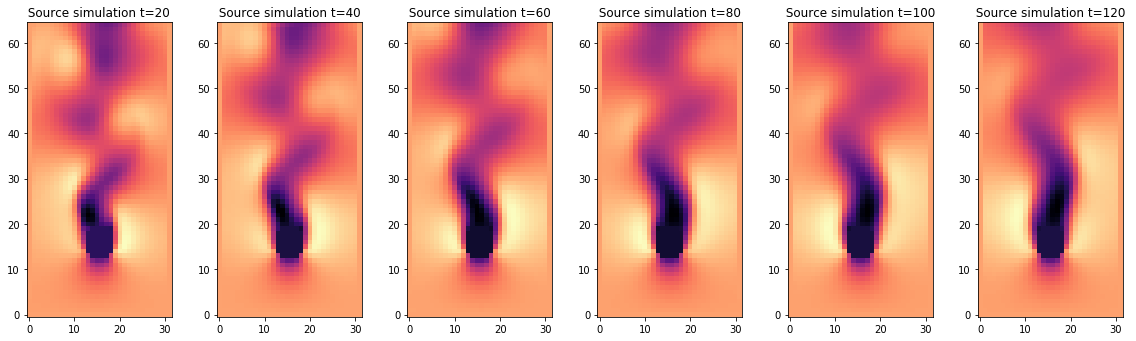

In [54]:
import pylab
b = 1 # batch index for the following comparisons

fig, axes = pylab.subplots(1, 6, figsize=(16, 5))
for i in range(1,7):
  v = steps_source[i*20].velocity.data[0].data[b,:,:,0] 
  axes[i-1].imshow( v , origin='lower', cmap='magma')
  axes[i-1].set_title(f" Source simulation t={i*20} ")
pylab.tight_layout()

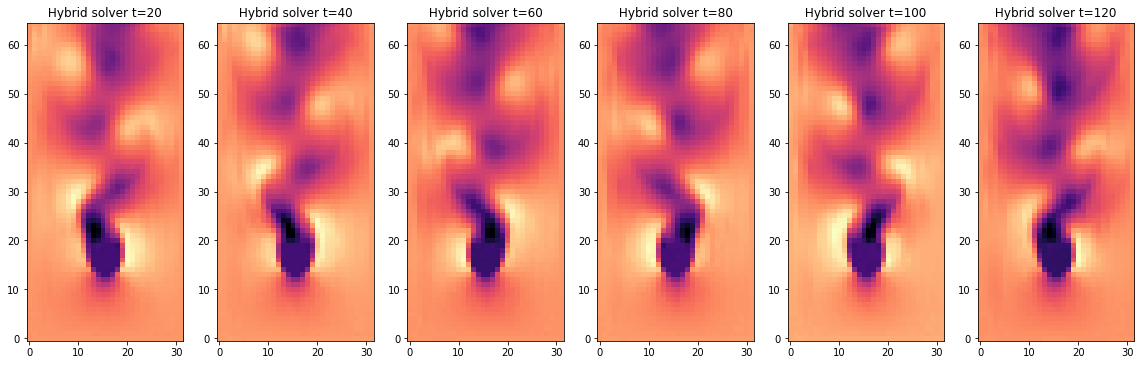

In [55]:
fig, axes = pylab.subplots(1, 6, figsize=(16, 5))
for i in range(1,7):
  v = steps_pred[i*20].velocity.data[0].data[b,:,:,0] 
  axes[i-1].imshow( v , origin='lower', cmap='magma')
  axes[i-1].set_title(f" Hybrid solver t={i*20} ")
pylab.tight_layout()

They both start out with the same initial state at $t=0$ (a downsampled solution from the reference solution manifold), and at $t=20$ the solutions still share similarities. Over time, the source version strongly diffuses the strucutres in the flow and looses momentum. The flow behind the obstacles becomes straight, and lacks clear vortices. 

The version produced by the hybrid solver does much better. It preserves the vortex shedding even after more than one hundred updates. Note that both outputs were produced by the same underlying solver. The second version just profits from the learned corrector which has learned to revert the overly strong dissipation of the solver. However, it also produces some visible axis aligned structures, especially near the sides of the domain. These could be alleviated with improved training setups, e.g., more look-ahead, and a larger model.

We can also compare and quantify how the models do w.r.t. reference data. The next cell plots one time step of the three versions: the reference data after 50 steps, and the re-simulated version of the source and our hybrid solver, together with a per-cell error of the two:

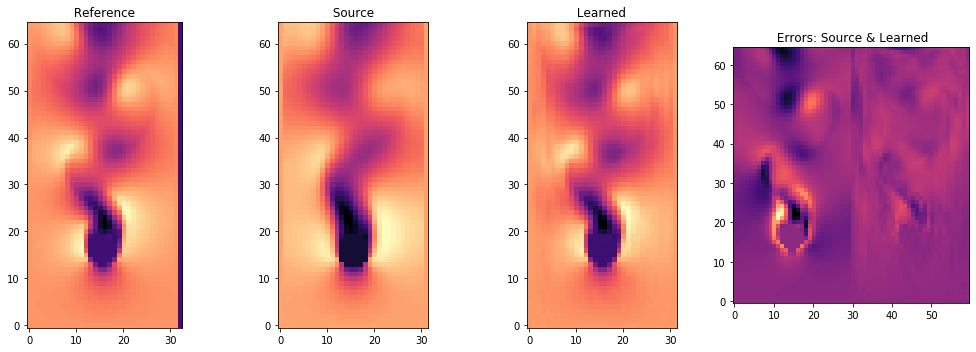

In [56]:
index = 50 # time step index

ref = [ math.concat( dataset_test.dataPreloaded[ dataset_test.dataSims[b] ][ j ][1] , axis=0) for j in range(121) ]

fig, axes = pylab.subplots(1, 4, figsize=(14, 5))

v = ref[index][:,:,0] 
axes[0].imshow( v , origin='lower', cmap='magma')
axes[0].set_title(f" Reference ")

v = steps_source[index].velocity.data[0].data[b,:,:,0] 
axes[1].imshow( v , origin='lower', cmap='magma')
axes[1].set_title(f" Source ")

v = steps_pred[index].velocity.data[0].data[b,:,:,0] 
axes[2].imshow( v , origin='lower', cmap='magma')
axes[2].set_title(f" Learned ")

# show error side by side
err_source = ref[index][:,1:-2,0] - steps_source[index].velocity.data[0].data[b,:,1:-1,0] 
err_pred   = ref[index][:,1:-2,0] - steps_pred[index].velocity.data[0].data[b,:,1:-1,0] 
v = np.concatenate([err_source,err_pred], axis=1)
axes[3].imshow( v , origin='lower', cmap='magma')
axes[3].set_title(f" Errors: Source & Learned")

pylab.tight_layout()


This shows very clearly how the pure source simulation in the middle deviates from the reference on the left. Apart from the slight vertical streaks, the learned version stays much closer to the reference solution. 

The two per-cell error images on the right also illustrate this: the source version has much larger errors that show how it systematically underestimates the vortices that should form. The error for the learned version is much more evenly distributed, and significantly smaller.

Next, we can quantify these observations:

MAE for source: 0.05912385508418083 , and hybrid: 0.0402643121778965


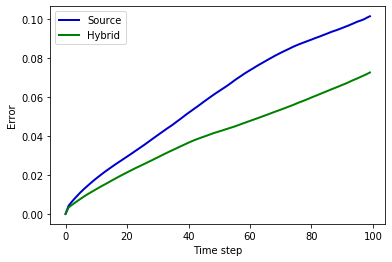

In [57]:
errors_source, errors_pred = [], []
for index in range(100):
  vs = ref[index][:,1:-2,0] - steps_source[index].velocity.data[0].data[b,:,1:-1,0] 
  vp = ref[index][:,1:-2,0] - steps_pred[index].velocity.data[0].data[b,:,1:-1,0] 
  errors_source.append(np.mean(np.abs(vs))) 
  errors_pred.append(np.mean(np.abs(vp)))
  #print("Errors for step "+format(index)+" source: "+format(np.mean(np.abs(vs))) +" , hybrid: "+format(np.mean(np.abs(vp))))

fig = pylab.figure().gca()
pltx = np.linspace(0,99,100)
fig.plot(pltx, errors_source, lw=2, color='mediumblue', label='Source')  
fig.plot(pltx, errors_pred,   lw=2, color='green', label='Hybrid')
pylab.xlabel('Time step'); pylab.ylabel('Error'); fig.legend()

print("MAE for source: "+format(np.mean(errors_source)) +" , and hybrid: "+format(np.mean(errors_pred)) )


The overall mean absolute error (MAE) is almost 50% larger for the regular simulation. The graph below shows this behavior over time: the error of the source version is clearly above the errors of the hybrid simulator.

This concludes our evaluation. Note that the improved behavior of the hybrid solver is difficult to reliably measure with simple vector norms such as an MAE or $L^2$ norm. To achieve this, we'd need to employ other, domain specific metrics. In this case, metrics for fluids based on vorticity and turbulence properties of the flow would be applicable. However, in this text we instead want to focus on DL-related topics, and target another inverse problem with differentiable physics solvers in the next chapter.

---

## Next steps

* Modify the training to further reduce the training error. With the _medium_ network you should be able to get the loss down to around 1.

* Use the external github code to generate new test data, and run your model on these cases. You'll see that a reduced training error not always directly correlates with an improved test performance.

* Turn off the differentiable physics training (by setting `msteps=1`), and compare it with the DP version.

* Likewise, train a model with a larger `msteps` setting, e.g., 8 or 16. Note that due to the recurrent nature of the training, you'll probabaly have to load a pre-trained state to stabilize the first iterations.